# Sequence Log-Probabilities from ESM Models

This notebook generates the figure showing sequence log-probabilities from ESM-2, ESM3, and ESM-C models, both unnormalized and length-normalized, grouped by binding strength.

## Reproducibility Note
This notebook sets all relevant random seeds to ensure reproducible results. The analysis is deterministic and does not involve random sampling.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Set plot style
plt.style.use('default')

print(f"Random seed set to: {RANDOM_SEED}")
print("Note: This analysis is deterministic and does not involve random sampling.")

Random seed set to: 42
Note: This analysis is deterministic and does not involve random sampling.


In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Add the repo's scripts directory to Python path for theme import
theme_path = os.path.abspath('../adaptyv/adaptyv_analyses/scripts/plotting_python')
if theme_path not in sys.path:
    sys.path.insert(0, theme_path)

# Import the Adaptyv theme from the repo
import blog_post_theme as adaptyv_theme

# Apply the theme
adaptyv_theme.set_adaptyv_matplotlib_theme()

# Get color palettes
palettes = adaptyv_theme.get_adaptyv_palettes()

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

print(f"Random seed set to: {RANDOM_SEED}")
print("Note: This analysis is deterministic and does not involve random sampling.")
print(f"Theme loaded from repo: {theme_path}")

Random seed set to: 42
Note: This analysis is deterministic and does not involve random sampling.
Theme loaded from repo: /Users/qamar/Downloads/adaptyv_nature_paper/egfr2024_post_competition/adaptyv/adaptyv_analyses/scripts/plotting_python


In [3]:
# Load the data from parquet file
df_data = pd.read_parquet('data/unioned_egfr_features.parquet')

# Filter for rows with non-null kd_nm values (as in original analysis)
df_data_kd = df_data[df_data['kd_nm'].notna()].copy()

print(f"Number of rows with kd_nm values: {len(df_data_kd)}")
print(f"Binding strength distribution:")
print(df_data_kd['binding_strength'].value_counts())

Number of rows with kd_nm values: 88
Binding strength distribution:
binding_strength
medium    44
weak      33
strong    11
Name: count, dtype: int64


In [4]:
# Define the log probability columns to analyze
# Focus on ESM2, ESM3, and ESMC models
log_prob_cols = [
    'esm3_open_small_log_prob',
    'esmc_600m_log_prob', 
    'esmc_300m_log_prob',
    'esm2_650m_log_prob',
]

log_prob_cols_normalized = [
    'esm3_open_small_log_prob_normalized',
    'esmc_600m_log_prob_normalized',
    'esmc_300m_log_prob_normalized', 
    'esm2_650m_log_prob_normalized',
]

# Model labels for the plot
model_labels = [
    'ESM3-open-small LP',
    'ESMC-600m LP',
    'ESMC-300m LP',
    'ESM2-650m LP'
]

In [5]:
# Prepare data for plotting
# Set binding strength order
order = ["weak", "medium", "strong"]
df_data_kd['binding_strength'] = pd.Categorical(df_data_kd['binding_strength'], 
                                                categories=order, ordered=True)

# Group by binding strength and compute mean and std for each metric
grouped = df_data_kd.groupby('binding_strength', observed=False)

# Compute statistics for unnormalized metrics
stats_unnorm = grouped[log_prob_cols].agg(['mean', 'std']).reset_index()
stats_unnorm = stats_unnorm.set_index('binding_strength').reindex(order)

# Compute statistics for normalized metrics  
stats_norm = grouped[log_prob_cols_normalized].agg(['mean', 'std']).reset_index()
stats_norm = stats_norm.set_index('binding_strength').reindex(order)

# Get counts for each binding strength
counts = df_data_kd['binding_strength'].value_counts()

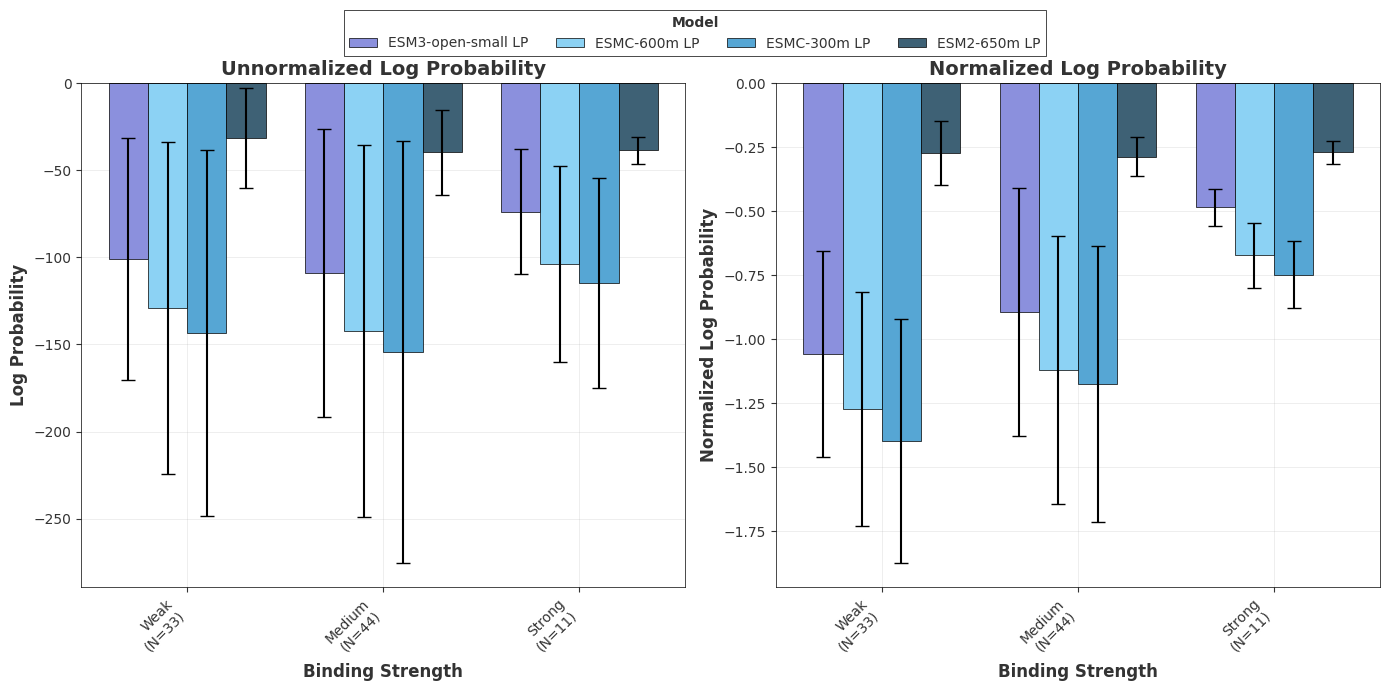

Sequence log-probabilities from ESM-2, ESM3, and ESM-C models, unnormalized and length-normalized.


In [6]:
# Create figure: Side-by-side bar plots with Adaptyv theme
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# Define colors for models using the repo's palette style
model_colors = {
    "ESM3-open-small LP": "#8B90DD",
    "ESMC-600m LP": "#8CD2F4", 
    "ESMC-300m LP": "#56A6D4",
    "ESM2-650m LP": "#3E6175"
}
colors = [model_colors.get(label, "#808080") for label in model_labels]

# X positions for the binding strength categories
x = np.arange(len(order))
total_width = 0.8  # Total width allocated for bars in one group
num_models = len(log_prob_cols)
bar_width = total_width / num_models  # Width of each individual bar

# --- Left subplot: Unnormalized Log Probability ---
ax_left = axs[0]
for j, (metric, label) in enumerate(zip(log_prob_cols, model_labels)):
    # Calculate offset so that bars for each metric are side by side
    positions = x - total_width/2 + j * bar_width + bar_width/2
    
    # Extract means and stds for the metric
    means = stats_unnorm.loc[order, (metric, 'mean')]
    stds = stats_unnorm.loc[order, (metric, 'std')]
    
    ax_left.bar(positions, means, yerr=stds, width=bar_width, capsize=5,
               label=label, color=colors[j], edgecolor='black', linewidth=0.5)

# Format left subplot
x_labels = [f"{cat.capitalize()}\n(N={counts.get(cat, 0)})" for cat in order]
ax_left.set_xticks(x)
ax_left.set_xticklabels(x_labels, rotation=45, ha='right')
ax_left.set_xlabel("Binding Strength", fontsize=12, fontweight='bold')
ax_left.set_ylabel("Log Probability", fontsize=12, fontweight='bold')
ax_left.set_title("Unnormalized Log Probability", fontsize=14, fontweight='bold')
ax_left.grid(True, alpha=0.3, linewidth=0.5)
ax_left.set_axisbelow(True)

# --- Right subplot: Normalized Log Probability ---
ax_right = axs[1]
for j, (metric, label) in enumerate(zip(log_prob_cols_normalized, model_labels)):
    positions = x - total_width/2 + j * bar_width + bar_width/2
    
    means = stats_norm.loc[order, (metric, 'mean')]
    stds = stats_norm.loc[order, (metric, 'std')]
    
    ax_right.bar(positions, means, yerr=stds, width=bar_width, capsize=5,
                label=label, color=colors[j], edgecolor='black', linewidth=0.5)

# Format right subplot
ax_right.set_xticks(x)
ax_right.set_xticklabels(x_labels, rotation=45, ha='right')
ax_right.set_xlabel("Binding Strength", fontsize=12, fontweight='bold')
ax_right.set_ylabel("Normalized Log Probability", fontsize=12, fontweight='bold')
ax_right.set_title("Normalized Log Probability", fontsize=14, fontweight='bold')
ax_right.grid(True, alpha=0.3, linewidth=0.5)
ax_right.set_axisbelow(True)

# Add legend above the plots with theme styling
handles, labels = ax_left.get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='upper center', ncol=num_models,
                    bbox_to_anchor=(0.5, 1.02), title="Model",
                    frameon=True, fancybox=False,
                    edgecolor='black', facecolor='white')
legend.get_frame().set_linewidth(0.5)
legend.get_title().set_fontweight('bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

print('Sequence log-probabilities from ESM-2, ESM3, and ESM-C models, unnormalized and length-normalized.')

Figure saved to plots/protein_llm_log_probabilities.png


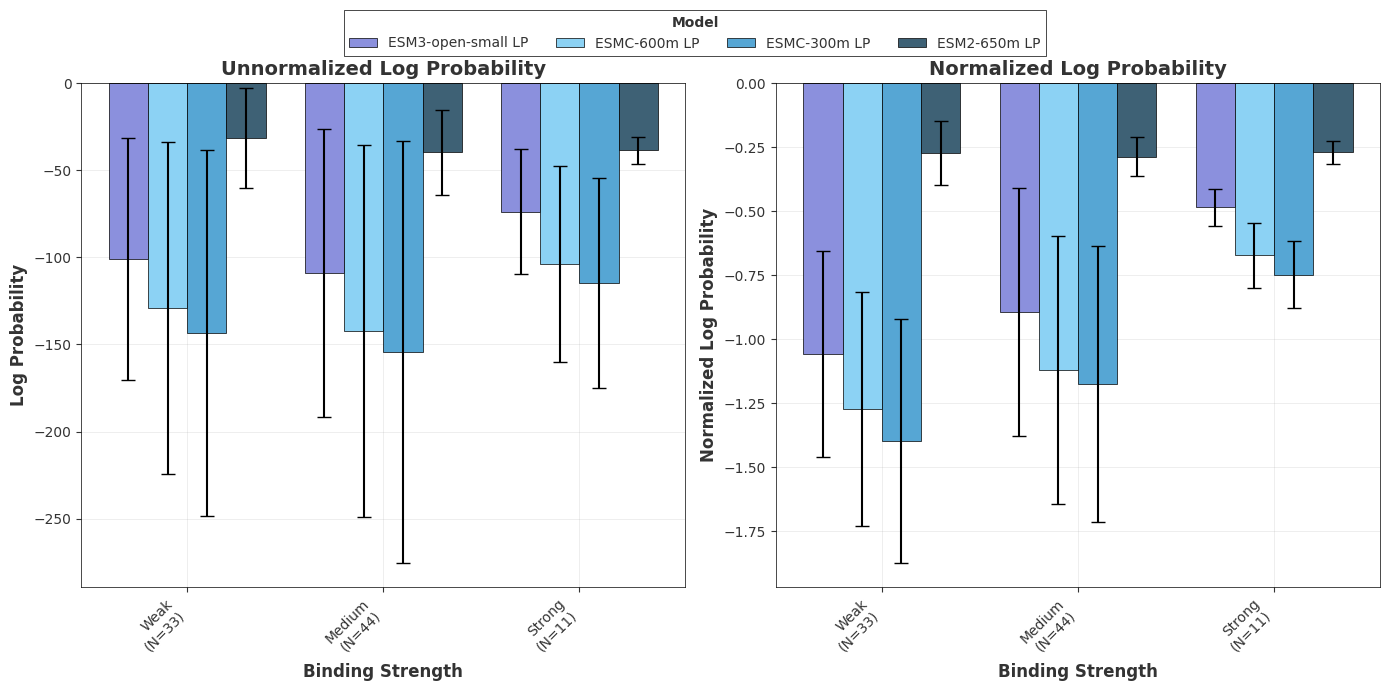

In [7]:
# Save the figure with Adaptyv theme settings
output_dir = 'plots'
os.makedirs(output_dir, exist_ok=True)

# Recreate figure for saving
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# Define colors for models using the repo's palette style
model_colors = {
    "ESM3-open-small LP": "#8B90DD",
    "ESMC-600m LP": "#8CD2F4", 
    "ESMC-300m LP": "#56A6D4",
    "ESM2-650m LP": "#3E6175"
}
colors = [model_colors.get(label, "#808080") for label in model_labels]

# X positions for the binding strength categories
x = np.arange(len(order))
total_width = 0.8
num_models = len(log_prob_cols)
bar_width = total_width / num_models

# Left subplot: Unnormalized Log Probability
ax_left = axs[0]
for j, (metric, label) in enumerate(zip(log_prob_cols, model_labels)):
    positions = x - total_width/2 + j * bar_width + bar_width/2
    means = stats_unnorm.loc[order, (metric, 'mean')]
    stds = stats_unnorm.loc[order, (metric, 'std')]
    ax_left.bar(positions, means, yerr=stds, width=bar_width, capsize=5,
               label=label, color=colors[j], edgecolor='black', linewidth=0.5)

x_labels = [f"{cat.capitalize()}\n(N={counts.get(cat, 0)})" for cat in order]
ax_left.set_xticks(x)
ax_left.set_xticklabels(x_labels, rotation=45, ha='right')
ax_left.set_xlabel("Binding Strength", fontsize=12, fontweight='bold')
ax_left.set_ylabel("Log Probability", fontsize=12, fontweight='bold')
ax_left.set_title("Unnormalized Log Probability", fontsize=14, fontweight='bold')
ax_left.grid(True, alpha=0.3, linewidth=0.5)
ax_left.set_axisbelow(True)

# Right subplot: Normalized Log Probability
ax_right = axs[1]
for j, (metric, label) in enumerate(zip(log_prob_cols_normalized, model_labels)):
    positions = x - total_width/2 + j * bar_width + bar_width/2
    means = stats_norm.loc[order, (metric, 'mean')]
    stds = stats_norm.loc[order, (metric, 'std')]
    ax_right.bar(positions, means, yerr=stds, width=bar_width, capsize=5,
                label=label, color=colors[j], edgecolor='black', linewidth=0.5)

ax_right.set_xticks(x)
ax_right.set_xticklabels(x_labels, rotation=45, ha='right')
ax_right.set_xlabel("Binding Strength", fontsize=12, fontweight='bold')
ax_right.set_ylabel("Normalized Log Probability", fontsize=12, fontweight='bold')
ax_right.set_title("Normalized Log Probability", fontsize=14, fontweight='bold')
ax_right.grid(True, alpha=0.3, linewidth=0.5)
ax_right.set_axisbelow(True)

# Add legend above the plots
handles, labels = ax_left.get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='upper center', ncol=num_models,
                    bbox_to_anchor=(0.5, 1.02), title="Model",
                    frameon=True, fancybox=False,
                    edgecolor='black', facecolor='white')
legend.get_frame().set_linewidth(0.5)
legend.get_title().set_fontweight('bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])

# Save the figure
output_path = os.path.join(output_dir, 'protein_llm_log_probabilities.png')
fig.savefig(output_path, dpi=300, bbox_inches='tight', 
           facecolor='white', edgecolor='none')
print(f"Figure saved to {output_path}")